### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [136]:
import pandas as pd

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [137]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000
mean,0.883279,761.545781,54.277552,209.982070,215.797343,62.086895
std,0.833093,1151.855864,56.299433,198.147531,272.329634,48.291224
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000
25%,-0.000000,153.000000,15.000000,80.000000,49.965000,27.682500
50%,0.693147,356.000000,34.000000,150.000000,118.950000,49.785000
75%,1.386294,886.500000,74.000000,268.000000,266.235000,84.280000
max,3.550250,13162.000000,315.000000,1440.000000,2464.840000,318.190000


### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

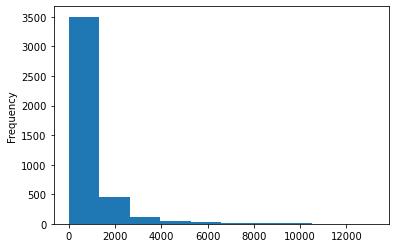

In [138]:
df = indicators[LABEL_FEATURE]
df.plot.hist()

In [139]:
quantiles = []
for i in range(0, 100, 5):
    quantile = df.quantile(i/100)
    quantiles.append(quantile)
    print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))

0% quantile: 1.0
5% quantile: 45.0
10% quantile: 74.0
15% quantile: 99.0
20% quantile: 127.4
25% quantile: 153.0
30% quantile: 185.0
35% quantile: 221.0
40% quantile: 260.0
45% quantile: 305.9
50% quantile: 356.0
55% quantile: 428.0
60% quantile: 501.0
65% quantile: 600.0
70% quantile: 740.4
75% quantile: 886.5
80% quantile: 1104.2
85% quantile: 1398.0
90% quantile: 1805.2
95% quantile: 2723.3


In [140]:
def calc_profile(tot_sales, quantiles):
    if (tot_sales < quantiles[10]):
        return "low"
    elif (tot_sales < quantiles[15]):
        return "medium"
    else:
        return "high"

indicators["spending_profile"] = indicators[LABEL_FEATURE].apply(lambda x : calc_profile(x, quantiles))

We drop the column we used to compute our label in order to proceed with classification

In [141]:
indicators = indicators.drop(LABEL_FEATURE, axis=1)

In [142]:
indicators.head()

,Entropy,iu,imax,tot_sales,mean_sales,spending_profile
CustomerID,,,,,,
12347,1.945910,103,319,481.21,68.744286,high
12348,1.386294,22,1254,178.71,44.677500,high
12350,-0.000000,17,197,65.30,65.300000,low
12352,2.079442,59,98,1337.42,167.177500,medium
12353,-0.000000,4,20,24.30,24.300000,low


### Discretizing the label

#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

adult = discretize_data(adult, variables)

## Classification with Decision Tree

In [150]:
df = indicators.copy(deep=True)
print(df)

             Entropy   iu  imax  tot_sales  mean_sales spending_profile
CustomerID                                                             
12347       1.945910  103   319     481.21   68.744286             high
12348       1.386294   22  1254     178.71   44.677500             high
12350      -0.000000   17   197      65.30   65.300000              low
12352       2.079442   59    98    1337.42  167.177500           medium
12353      -0.000000    4    20      24.30   24.300000              low
...              ...  ...   ...        ...         ...              ...
18280      -0.000000   10    45      47.65   47.650000              low
18281      -0.000000    7    54      39.36   39.360000              low
18282       0.693147   12    75      62.39   31.195000              low
18283       2.566599  263    61    1174.33   73.395625             high
18287       1.098612   59   488     104.55   34.850000             high

[4183 rows x 6 columns]


In [151]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.8)

In [152]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [153]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [154]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [155]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9066985645933014
Accuracy test set  0.7881685091126381
Precision train set  0.9055528971081456
Recall train set  0.9066985645933014
F1 score train set  0.9054996105838968
Support train set  (array([0.88372093, 0.9350348 , 0.86842105]), array([0.90909091, 0.96411483, 0.78947368]), array([0.89622642, 0.94935218, 0.82706767]), array([209, 418, 209]))
